In [1]:
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,MaxPool2D,LSTM,Dense,TimeDistributed,Flatten,Reshape,GlobalAveragePooling2D
from keras.layers import UpSampling2D
from keras.utils import np_utils

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [15]:
def create_sample(vidFileLoc,imgShape,timelineLen,numSamples=10,startingFrame=0):
    cap = cv2.VideoCapture(vidFileLoc)
    #Skip initial frames upto 'startingFrame'
    for skip in range(startingFrame):
        ret,frame=cap.read()
    X = []
    Y = []
    count=0
    fileFinished=False
    for _ in range(0,numSamples):
        x = []
        for i in range(0,timelineLen):
            count += 1
            ret,frame = cap.read()
            if frame is None:
                fileFinished=True
                break
            #print("Frame shape",frame.shape)
            #print("Frames read {}".format(count))
            #while ret == False:
            #    ret,frame = cap.read()            
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame,imgShape)
            x.append(frame)
        if fileFinished==True:
            break
        X.append(x)
        ret,y = cap.read()  
        y = cv2.cvtColor(y,cv2.COLOR_BGR2RGB)
        y = cv2.resize(y,imgShape)
        Y.append(y)
    cap.release() 
    X_ = np.array(X)
    Y_ = np.array(Y)
    return X_, Y_ 


def create_sample1(vidFileLoc,imgShape,timelineLen,numSamples=10,startingFrame=0):
    cap = cv2.VideoCapture(vidFileLoc)
    #Skip initial frames upto 'startingFrame'
    for skip in range(startingFrame):
        ret,frame=cap.read()
    X = []
    Y = []    
    # Fetch frames for numSamples + timelineLen + 1 length.
    frames = []
    for i in range(0,numSamples+timelineLen+1):
        ret,frame = cap.read()
        if frame is None:
            break
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame,imgShape)
        frames.append(frame)
    print("Total frames should be {}/{}".format(numSamples+timelineLen+1,len(frames)))
    # Now create sample by adding 'timelineLen' frames to X and 'timelineLen + 1 th' frame to Y.
    for i in range(0,len(frames)-(timelineLen+1)):
        #print(i)
        x = frames[i:i+timelineLen]
        y = frames[i+timelineLen]
        X.append(x)
        Y.append(y)    
    cap.release() 
    X_ = np.array(X)
    Y_ = np.array(Y)
    return X_, Y_ 


def totalFramesInFile(vidFileLoc):
    count=0
    cap = cv2.VideoCapture(vidFileLoc)
    while cap.isOpened() == True:
        ret,frame = cap.read()
        #print(frame.shape)
        if frame is None:
            break
        count += 1
        if(count%1000 == 0):
            #print("Read {} frames".format(count))
            pass
    cap.release()
    return count

def fetch_frames(vidFileLoc,imgShape,numSamples=10):
    cap = cv2.VideoCapture(vidFileLoc)
    X = []
    for i in range(0,numSamples):
        ret,frame = cap.read()
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame,imgShape)
        X.append(frame)
    X_ = np.array(X)
    return X_   

In [6]:
fileLoc = "Hyperloop.mp4"
totalFrames = totalFramesInFile(fileLoc)
print("Total frames in file",fileLoc,totalFrames)

Total frames in file Hyperloop.mp4 5338


In [8]:
fileLoc = "Hyperloop.mp4"
imgShape = (64,64)
timelineLen = 10
#numSamples=1000
startingFrame=0

# Compute total samples possible for totalFrames.
numSamples = totalFrames - (timelineLen + 1)

print("From given file total of {} samples are possible".format(numSamples))


From given file total of 5327 samples are possible


In [16]:
X,Y = create_sample1(fileLoc,imgShape,timelineLen,numSamples,startingFrame)
print(X.shape)
print(Y.shape)

Total frames should be 5338/5338
(5327, 10, 64, 64, 3)
(5327, 64, 64, 3)


In [29]:
# Save X and Y to file.
#np.save("/home/rajeev/Videos/X.npy",X)
#np.save("/home/rajeev/Videos/Y.npy",Y)

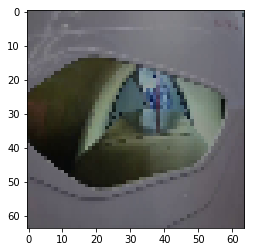

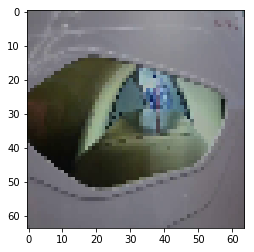

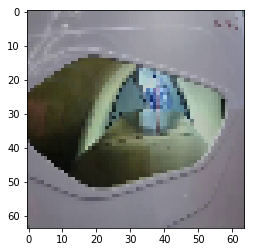

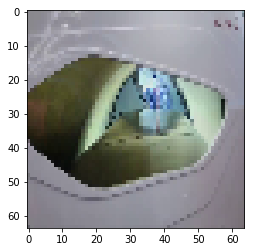

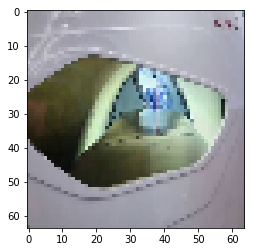

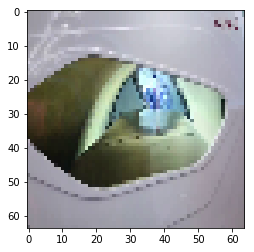

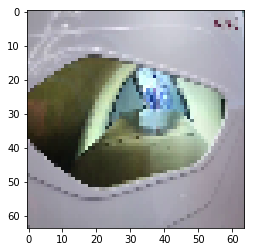

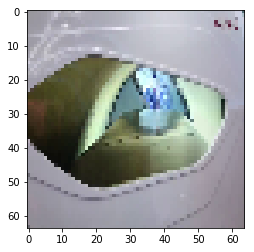

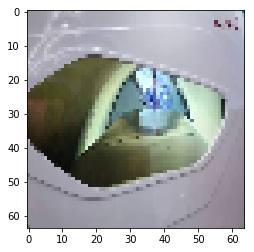

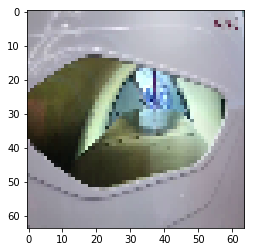

In [17]:
# Test if images are non black.
for img in X[4]:
    plt.imshow(img)
    plt.show()

In [22]:
from keras.applications.vgg16 import VGG16

vggModel = VGG16(include_top=False,input_shape=(64,64,3))
for layer in vggModel.layers:
    layer.trainable=False
    
intToLayer = dict((index,layer.name) for index,layer in enumerate(vggModel.layers))
layerToInt = dict((name,index) for index,name in intToLayer.items())

print("VGG model summary:")
print(vggModel.summary())

# create CNN model.
input_ = vggModel.input
output_ = vggModel.layers[layerToInt["block5_pool"]].output
cnnModel = Model(inputs = input_, outputs = output_)

print("==================================================================\n")
print("CNN model summary")
print(cnnModel.summary())

VGG model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0 

In [23]:
model = Sequential()

#model.add(TimeDistributed(input_shape=(10,64,64,3),layer = Conv2D(16,kernel_size=(2,2),padding="same",input_shape=(64,64,3),activation="relu")))
#model.add(TimeDistributed(MaxPool2D(strides=(2,2),padding="same")))
#model.add(TimeDistributed(Conv2D(32,kernel_size=(2,2),padding="same",activation="relu")))
#model.add(TimeDistributed(MaxPool2D(strides=(2,2),padding="same")))

model.add(TimeDistributed(input_shape=(10,64,64,3), layer=cnnModel))

model.add(TimeDistributed(GlobalAveragePooling2D()))
#model.add(TimeDistributed(Flatten()))

#model.add(LSTM(units=256,return_sequences=True))
model.add(LSTM(units=1024,return_sequences=True))
model.add(LSTM(units=2048))
model.add(Dense(8*8*256,activation="relu"))
model.add(Reshape(target_shape=(8,8,256)))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(128,kernel_size=(2,2),padding="same",activation="relu"))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(64,kernel_size=(2,2),padding="same",activation="relu"))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(3,kernel_size=(2,2),padding="same",activation="relu"))

#model.add(Dense(units=1024,activation="relu"))
#model.add(Dense(units=2048,activation="relu"))
#model.add(Dense(units=64*64*3,activation="linear"))
#model.add(Reshape(target_shape=(64,64,3)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 10, 2, 2, 512)     14714688  
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 512)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 1024)          6295552   
_________________________________________________________________
lstm_4 (LSTM)                (None, 2048)              25174016  
_________________________________________________________________
dense_2 (Dense)              (None, 16384)             33570816  
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 256)       0         
__________

In [24]:
model.compile(loss="mse",optimizer="rmsprop",metrics=["accuracy"])

In [25]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("LSTM_Video.hdf5",verbose=1,save_best_only=True)

hist = model.fit(X.astype("float32"),Y.astype("float32"),batch_size=16,epochs=10,
                 validation_split=0.2,callbacks=[checkpoint])

Train on 4261 samples, validate on 1066 samples
Epoch 1/10
4261/4261 [==============================] - 3004s - loss: 3488.9962 - acc: 0.7249 - val_loss: 2479.9575 - val_acc: 0.7667
Epoch 2/10
4261/4261 [==============================] - 2998s - loss: 2085.7965 - acc: 0.7916 - val_loss: 2478.2875 - val_acc: 0.8000
Epoch 3/10
4261/4261 [==============================] - 3003s - loss: 1747.9860 - acc: 0.8026 - val_loss: 2204.7683 - val_acc: 0.8218
Epoch 4/10
4261/4261 [==============================] - 2988s - loss: 1594.9319 - acc: 0.8073 - val_loss: 2272.0754 - val_acc: 0.8163
Epoch 5/10
4261/4261 [==============================] - 6555s - loss: 1498.2752 - acc: 0.8082 - val_loss: 2403.3139 - val_acc: 0.7999
Epoch 6/10
4261/4261 [==============================] - 19058s - loss: 1307.8202 - acc: 0.8404 - val_loss: 2280.7436 - val_acc: 0.8263
Epoch 7/10
4261/4261 [==============================] - 18322s - loss: 1169.5215 - acc: 0.8485 - val_loss: 2145.5995 - val_acc: 0.8682
Epoch 8/10
4

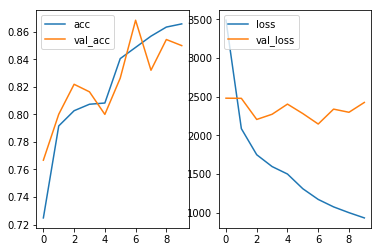

In [26]:
plt.subplot(1,2,1)
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])
plt.legend(["acc","val_acc"],loc="upper left")

plt.subplot(1,2,2)
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(["loss","val_loss"],loc="upper left")

In [38]:
model.load_weights("LSTM_Video.hdf5")

In [43]:
# Take a different file and create seed point.
fileLoc = "Police.mp4"
numSamples = 3
startingFrame = 10

X_test,Y_test = create_sample1(fileLoc,imgShape,timelineLen,numSamples,startingFrame)
print(X_test.shape)
print(Y_test.shape)

Total frames should be 14/14
(3, 10, 64, 64, 3)
(3, 64, 64, 3)


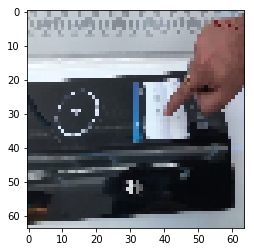

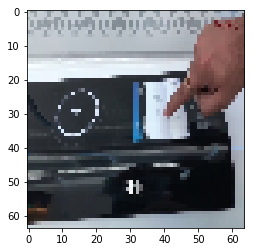

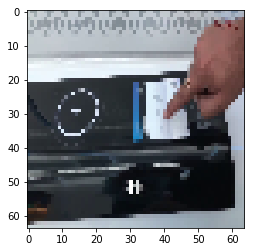

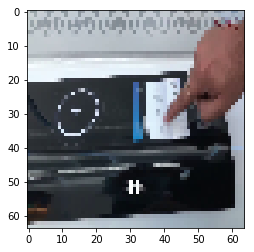

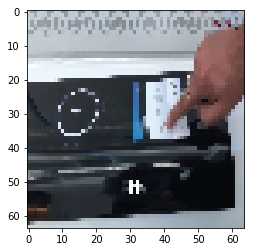

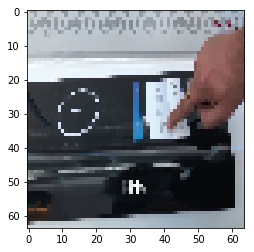

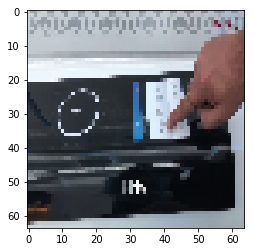

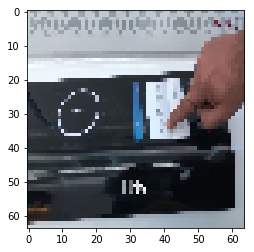

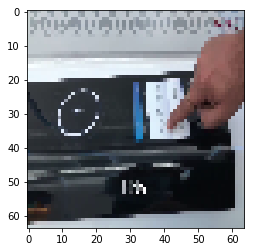

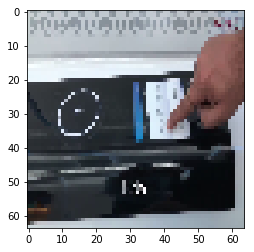

In [61]:
seedImgs = X[1500]

# Display seed video.
for img in seedImgs:
    plt.imshow(img.astype("uint8"))
    plt.show()

In [64]:
predLen=50
output=[]

xTest = seedImgs

for i in range(predLen):
    pred = model.predict(xTest[None,:])
    #plt.imshow(pred[0].astype("uint8"))
    #plt.show()
    output.append(pred)
    xTest = xTest[1:]
    #print(xTest.shape,pred.shape)
    xTest = np.vstack((xTest,pred))
    #print("xTest.shape",xTest.shape)
    #print("pred.shape",pred.shape)

output = np.array(output)
print("output.shape",output.shape)

output.shape (50, 1, 64, 64, 3)


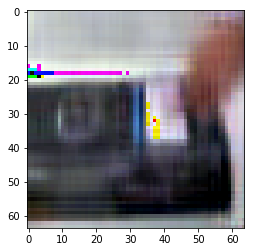

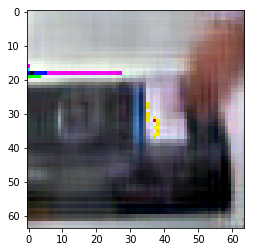

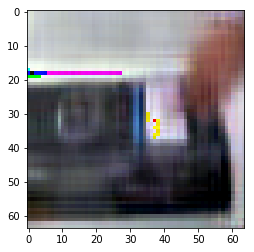

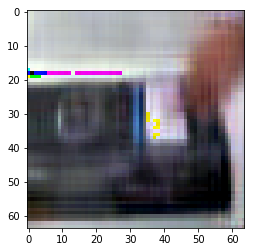

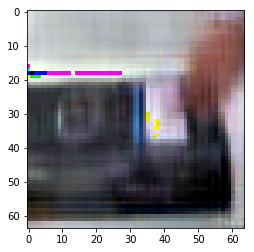

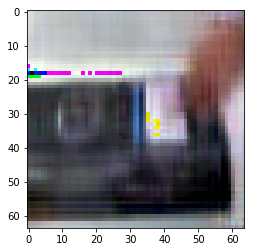

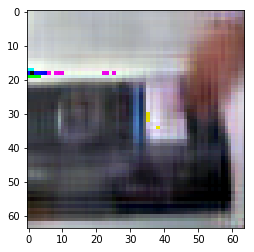

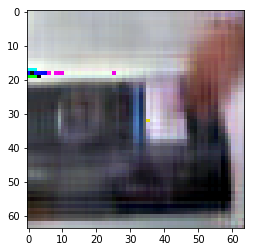

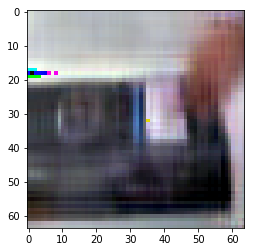

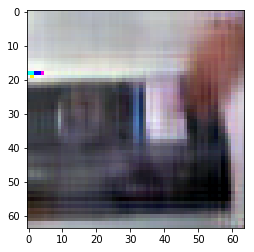

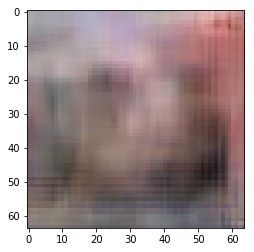

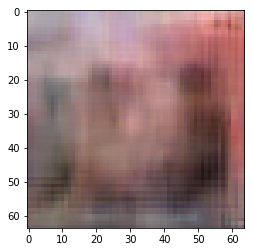

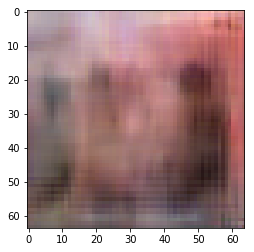

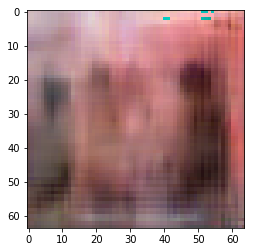

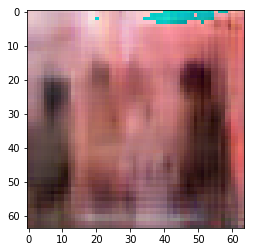

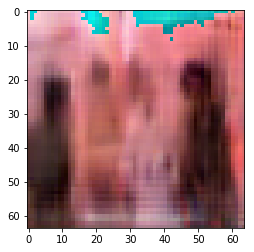

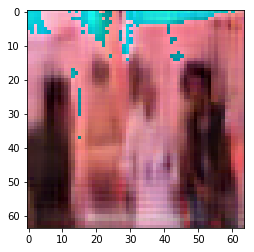

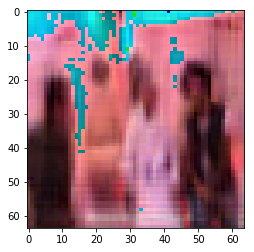

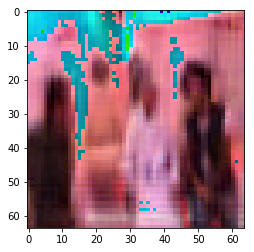

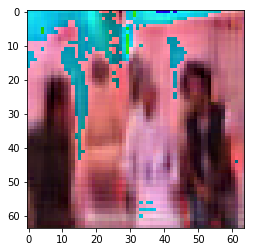

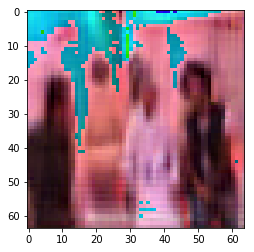

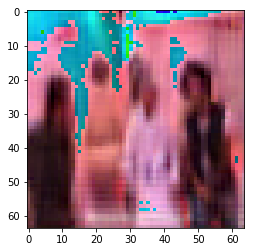

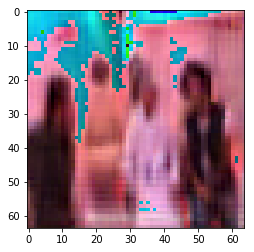

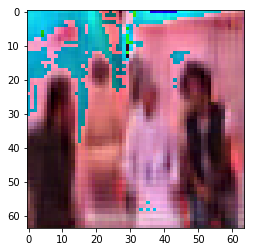

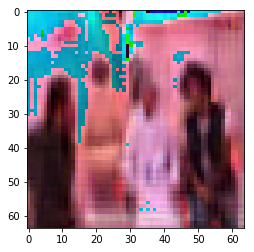

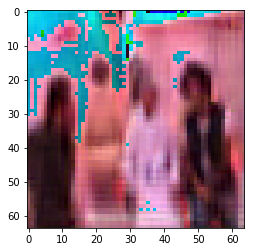

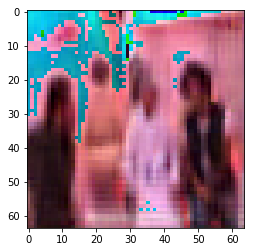

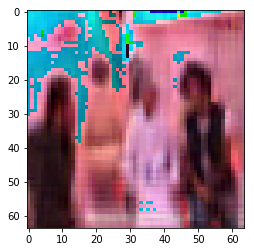

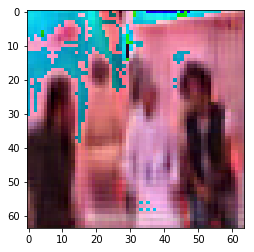

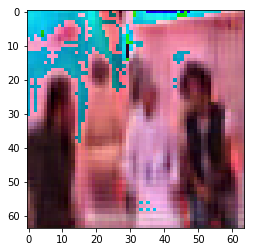

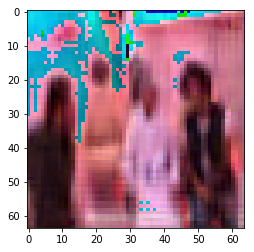

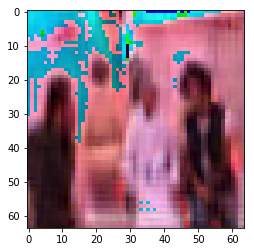

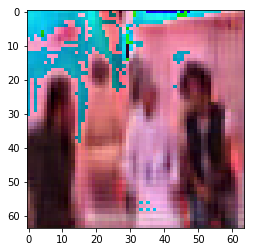

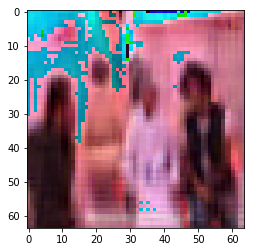

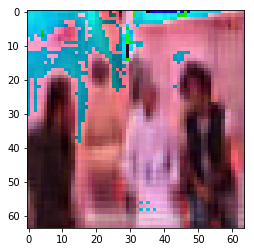

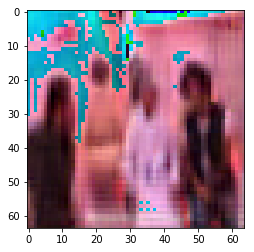

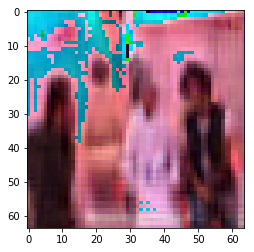

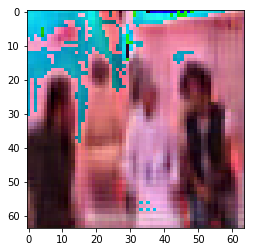

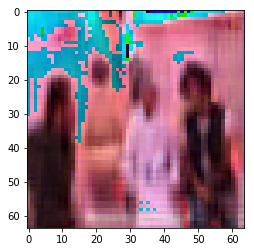

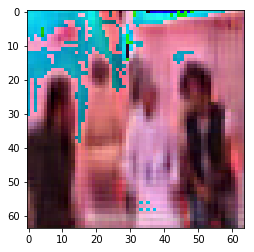

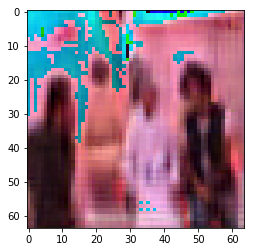

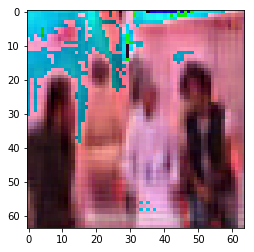

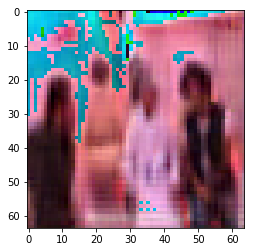

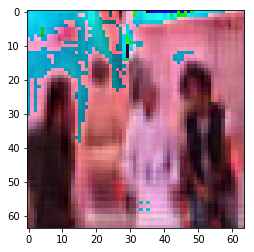

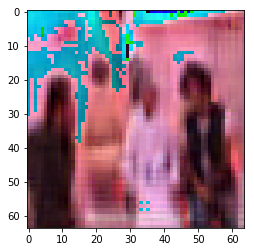

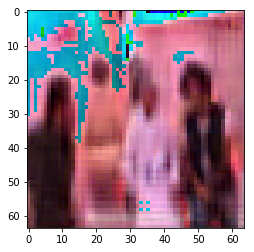

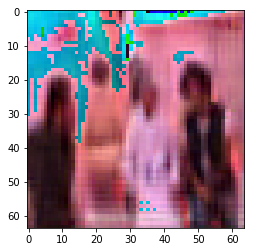

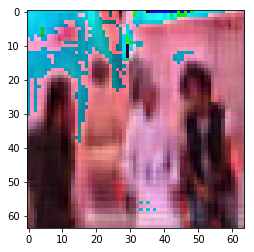

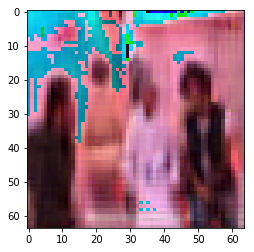

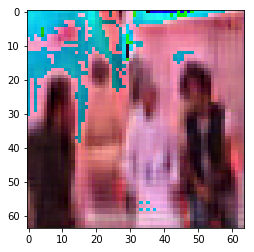

In [65]:
# Display generated output.

for img in output:
    plt.imshow(img[0].astype("uint8"))
    plt.show()

In [17]:
outFileLoc = "Output.mp4"
fps=1
size = (64,64)
fourcc = cv2.VideoWriter_fourcc('D', 'I', 'V', 'X')
out = cv2.VideoWriter(outFileLoc,fourcc, fps, size)
for img in output:
   print(img.shape)
   out.write(img[0].astype("uint8"))
out.release()

(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)
(1, 64, 64, 3)


In [79]:
X[0].shape

(10, 64, 64, 3)